<a href="https://colab.research.google.com/github/LMAPcoder/Advanced-Computer-Vision/blob/main/ACV_sheet10_adversarial_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Advance Computer Vision

##Exercise Sheet 10

Robustness against adversarial attacks refers to the ability of a machine learning model to maintain its performance and make correct predictions even when it is presented with adversarial examples.

Adversarial examples are inputs to the model that have been deliberately modified in a subtle way to cause the model to make a mistake. These modifications are often imperceptible to humans but can significantly affect the model’s output.

###Task 1 – Carlini-Wagner Attack

The Carlini and Wagner attack is one of the most effective methods for generating adversarial examples. It formulates the problem of finding adversarial examples as an optimization problem. It seeks to find the smallest perturbation to the input that will cause the model to misclassify it.

In [ ]:
# Importing libraries

import tensorflow as tf
tf.random.set_seed(1)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback

import numpy as np
np.random.seed(1)
import IPython.display
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm

#### Training original model

MNIST Dataset

In [ ]:
# Load and preprocess training data (MNIST)
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000, 10)


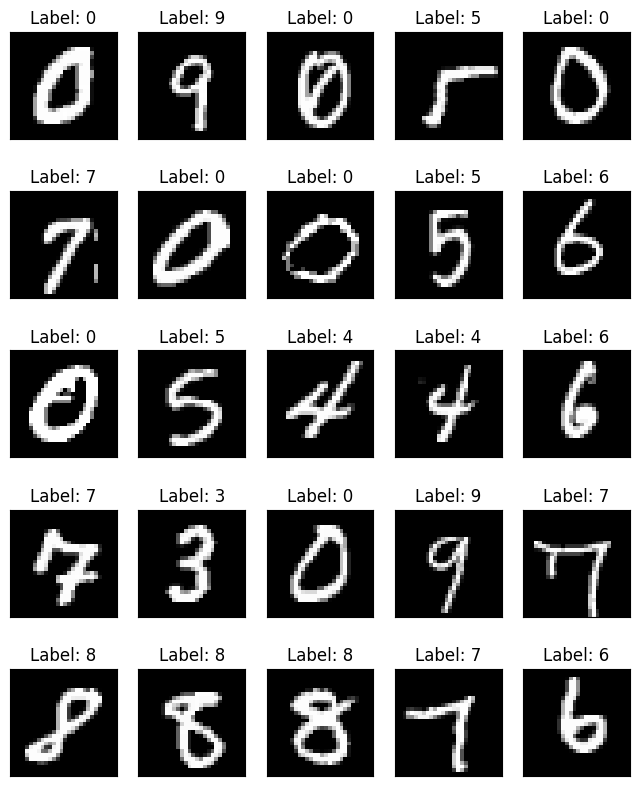

In [ ]:
#Printing a random subset of training dataset along with the labels

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(8,10))
for i in range(5):
    for j in range(5):
        idx = np.random.randint(train_images.shape[0])
        ax[i,j].set_title(f'Label: {np.argmax(train_labels[idx])}')
        ax[i,j].imshow(train_images[idx], cmap='gray')
        ax[i,j].axes.yaxis.set_visible(False)
        ax[i,j].axes.xaxis.set_visible(False)

CNN

In [ ]:
# simple CNN for MNIST data set
def define_model():
    inputs = tf.keras.Input(shape=(28, 28, 1), name='inputs')
    x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(10)(x) # no softmax
    model = keras.Model(inputs,outputs)
    model.summary()
    return model

In [ ]:
model = define_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                             

Training CNN

In [ ]:
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.001

OPT = optimizer=keras.optimizers.Adam(
    learning_rate=LEARNING_RATE
)

LOSS = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(loss=LOSS,optimizer=OPT,metrics=["accuracy"])

In [ ]:
# Train model
%%time
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
1875/1875 [==============================] - 180s 94ms/step - loss: 0.1945 - accuracy: 0.9407
Epoch 2/5
1875/1875 [==============================] - 158s 84ms/step - loss: 0.0871 - accuracy: 0.9739
Epoch 3/5
1875/1875 [==============================] - 155s 83ms/step - loss: 0.0707 - accuracy: 0.9786
Epoch 4/5
1875/1875 [==============================] - 156s 83ms/step - loss: 0.0597 - accuracy: 0.9820
Epoch 5/5
1875/1875 [==============================] - 152s 81ms/step - loss: 0.0523 - accuracy: 0.9840
CPU times: user 19min 43s, sys: 23.8 s, total: 20min 6s
Wall time: 13min 27s


Image to perturbate

True class:  7


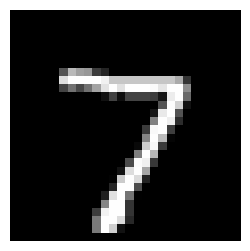

In [ ]:
# Data point in test set

x0 = test_images[0:1]
y0 = test_labels[0:1]

original_image = np.squeeze(x0)

print('True class: % i' % np.argmax(y0))

plt.figure(figsize = (3,3))
plt.imshow(original_image, cmap='gray')
plt.axis('off')
plt.show()

Prediction made by the model for the image

In [ ]:
# Prediction made by the model

with np.printoptions(precision=2, suppress=True):
    predictions = model.predict(x0)[0]
    print("Model output:", predictions)

with np.printoptions(precision=6, suppress=True):
    probs_prediction = tf.nn.softmax(predictions)
    print("Probabilities:", probs_prediction.numpy())

class_prediction = tf.argmax(probs_prediction)
print("Class predicted:", class_prediction.numpy())
one_hot_class_prediction = tf.one_hot(class_prediction, depth=len(predictions))
print("One-hot encoded output:", one_hot_class_prediction.numpy())

1/1 [==============================] - 0s 169ms/step
Model output: [ -9.89  -1.71  -0.25  -0.34  -7.82 -11.81 -22.85  17.89 -10.07  -1.91]
Probabilities: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Class predicted: 7
One-hot encoded output: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


#### Training perturbation

Adversarial attack with Carlini-Warner approach

In [ ]:
def custom_regularizer(inputs):
    def regularizer(weight_matrix):
        return tf.norm(weight_matrix - inputs, ord='euclidean')
    return regularizer

In [ ]:
# Perturbation layer
class Perturbation(tf.keras.layers.Layer):
  def __init__(self,  name='perturbation'):
    super().__init__(name=name)
  def build(self, input_shape):
    self.w = self.add_weight(shape=input_shape[1:],
                             initializer="random_normal",
                             trainable=True,
                             name='w')
  def call(self, inputs):
    #regularization term in Carlini-Warner formula
    self.add_loss(custom_regularizer(inputs)(self.w))
    return inputs + self.w

In [ ]:
# Model with perturbation layer

def define_perturbated_model(model):
  inputs = model.input
  x = Perturbation()(inputs)
  for layer in model.layers[1:]:
    x = layer(x)
    layer.trainable = False # Layers of original model remain frozen
  outputs = x
  perturbated_model = keras.Model(inputs, outputs)
  perturbated_model.summary()
  return perturbated_model

In [ ]:
pertubated_model = define_perturbated_model(model)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 perturbation (Perturbation  (None, 28, 28, 1)         784       
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0   

Carlini-Wagner objective function

\begin{align}
x^{*} &= \arg \min_{x \in \mathcal{X}}  \|\textbf{x}-\textbf{x}_0\|_2^2 + \lambda \max \left(\max_{j \neq t}\{f_{\theta}(\textbf{x})_j\}-f_{\theta}(\textbf{x})_t, -\kappa \right)
\end{align}



where:

$f_{\theta}(\textbf{x})$ are the class scores (logits)

t is the target class

λ is a hyperparameter that trades off between confidence in target classification and strength of perturbation

κ is a margin that control the strength of the confidence of the model on the wrong label

$\delta = \|\textbf{x}\|$

In [ ]:
# @tf.function
# def Carlini_Wagner(y_true, y_pred, λ=0.9, κ=0.0):
#   y_pred = tf.squeeze(y_pred)
#   y_true = tf.squeeze(y_true)
#   t = tf.math.argmax(y_true, output_type=tf.dtypes.int32)
#   y_t = y_pred[t]
#   y_pred = tf.concat([y_pred[:t],y_pred[t+1:]],0)
#   L = tf.math.maximum(tf.reduce_max(y_pred) - y_t,-κ)
#   return λ*L

In [ ]:
# Carlini-Warger loss (second term)

class Carlini_Wagner(tf.keras.losses.Loss):
    def __init__(self, name='carlini-wagner', λ=0.9, kappa=0.0):
        self.margin = kappa
        self.weight = λ
        super().__init__(name=name)

    def call(self, y_true, y_pred):

        y_j = tf.math.multiply(1-y_true, y_pred)
        y_t = tf.math.multiply(y_true, y_pred)
        L = tf.math.maximum(tf.reduce_max(y_j) - tf.reduce_max(y_t),-self.margin)

        return self.weight *  L

In [ ]:
# Predictions made by the original and perturbed model before training

with np.printoptions(precision=4, suppress=True):

    predictions_original = model.predict(x0)[0]
    predictions_perturbed = pertubated_model.predict(x0)[0]

    probs_prediction = tf.nn.softmax(predictions_original)
    print("Original model output:", probs_prediction.numpy())

    probs_prediction = tf.nn.softmax(predictions_perturbed)
    print("Perturbed model output:", probs_prediction.numpy(), "before training")

probs_prediction = tf.nn.softmax(predictions_original)
class_prediction = tf.argmax(probs_prediction)
print("Original class predicted:", class_prediction.numpy())

probs_prediction = tf.nn.softmax(predictions_perturbed)
class_prediction = tf.argmax(probs_prediction)
print("Class predicted:", class_prediction.numpy())

1/1 [==============================] - 0s 91ms/step
Original model output: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Perturbed model output: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] before training
Original class predicted: 7
Class predicted: 7


In [ ]:
#Input shape
print("Input shape:", x0.shape)

# Perturbation shape
x0_bar = pertubated_model.get_layer('perturbation').get_weights()
delta = np.linalg.norm(np.squeeze(x0_bar), ord=2)
print("Perturbation shape:", x0_bar[0].shape)
print("Initial perturbation norm2:", delta)

# Target class
y0f = [3] #TARGET CLASS "3"
print("Target class:", y0f[0])
y0f = tf.keras.utils.to_categorical(y0f, num_classes=10)
print("One-hot encoded target class:", y0f)
print("Output shape:", y0f.shape)

Input shape: (1, 28, 28)
Perturbation shape: (28, 28, 1)
Initial perturbation norm2: 0.49713555
Target class: 3
One-hot encoded target class: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Output shape: (1, 10)


In [ ]:
# Custom callback to print loss and delta
class customCallback(Callback):
    def __init__(self, layer_name, log_interval):
        self.layer_name = layer_name
        super(customCallback, self).__init__()
        self.log_interval = log_interval

    def on_epoch_end(self, epoch, logs=None):

        if (epoch+1) % self.log_interval == 0:
            weights = self.model.get_layer(self.layer_name).get_weights()
            delta = np.linalg.norm(np.squeeze(weights), ord=2)

            logs = logs or {}
            logs['delta'] = delta
            loss = logs.get('loss')
            print(f'Epoch {epoch + 1}: loss = {loss:.3f} delta = {delta:.3f}', end='\n')

In [ ]:
%%time

LEARNING_RATE = 0.0001
EPOCHS = 2000
log_interval = 200
LAMBDA = 0.9
KAPPA = 1.0

print(f"Lambda: {LAMBDA}\nKappa: {KAPPA}")

# custom_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
LOSS = Carlini_Wagner(λ=LAMBDA, kappa=KAPPA)

OPT = keras.optimizers.Adam(
    learning_rate=LEARNING_RATE
)

pertubated_model.compile(loss=LOSS, optimizer=OPT)
history = pertubated_model.fit(x0, y0f, epochs=EPOCHS, callbacks=[customCallback('perturbation', log_interval)], verbose=0)

Lambda: 0.9
Kappa: 1.0
Epoch 200: loss = 18.116 delta = 0.517
Epoch 400: loss = 25.622 delta = 0.561
Epoch 600: loss = 18.317 delta = 0.616
Epoch 800: loss = 16.610 delta = 0.686
Epoch 1000: loss = 13.340 delta = 0.782
Epoch 1200: loss = 11.065 delta = 0.898
Epoch 1400: loss = 7.630 delta = 0.995
Epoch 1600: loss = 7.409 delta = 1.051
Epoch 1800: loss = 7.395 delta = 1.079
Epoch 2000: loss = 7.375 delta = 1.105


In [ ]:
# Perturbation shape after training
x0_bar = pertubated_model.get_layer('perturbation').get_weights()
perturbation = np.squeeze(x0_bar)
delta = np.linalg.norm(perturbation, ord=2)
print("Perturbation shape:", perturbation.shape)
print("End perturbation norm2:", delta)

Perturbation shape: (28, 28)
End perturbation norm2: 1.105038


In [ ]:
with np.printoptions(precision=4, suppress=True):

    predictions_original = model.predict(x0)[0]
    predictions_perturbed = pertubated_model.predict(x0)[0]

    probs_prediction = tf.nn.softmax(predictions_original)
    print("Original model output:", probs_prediction.numpy())

    probs_prediction = tf.nn.softmax(predictions_perturbed)
    print("Perturbed model output:", probs_prediction.numpy(), "before training")

probs_prediction = tf.nn.softmax(predictions_original)
class_prediction = tf.argmax(probs_prediction)
print("Original class predicted:", class_prediction.numpy())

probs_prediction = tf.nn.softmax(predictions_perturbed)
class_prediction = tf.argmax(probs_prediction)
print("Class predicted:", class_prediction.numpy())

1/1 [==============================] - 0s 93ms/step
Original model output: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Perturbed model output: [0.     0.     0.0001 0.9845 0.     0.     0.     0.0153 0.     0.    ] before training
Original class predicted: 7
Class predicted: 3


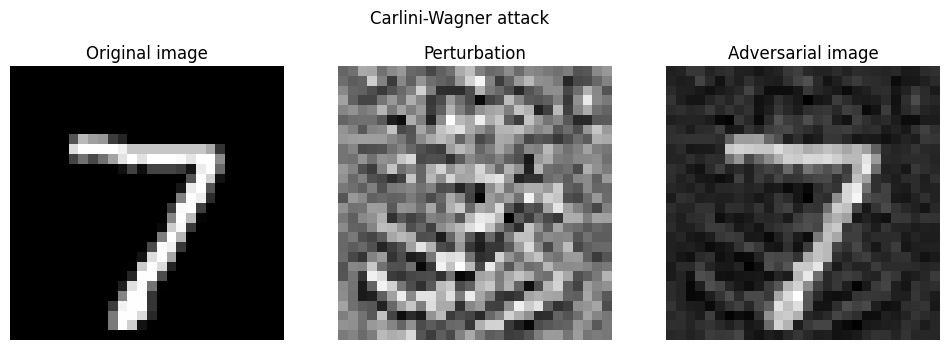

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

fig.suptitle('Carlini-Wagner attack')

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original image')
axes[0].axis('off')

axes[1].imshow(perturbation, cmap='gray')
axes[1].set_title('Perturbation')
axes[1].axis('off')

axes[2].imshow(original_image+perturbation, cmap='gray')
axes[2].set_title('Adversarial image')
axes[2].axis('off')

plt.show()

###Task 2 – Sparse Perturbations

Hoyer-Square regularizer

The Hoyer-Square regularizer is a sparsity-inducing regularizer used to encourage sparsity in the weights of a neural network. According Yang et al. (2020) this sparsity-inducing regularizer has the advantage to be differentiable almost everywhere and scale-invariant.

\begin{align}
 H_S(W) = \frac{\left(\sum_{i}|w_i|\right)^2}{\sum_{i}w_{i}^{2}}
\end{align}

where $w_i$ are the weights of the neural network

Applying the Hoyer-Square regularizer to the Carlini-Wagner formulation:

\begin{align}
x^{*} = \arg \min_{x \in \mathcal{X}}  \frac{\left(\sum_{i}|x_i - x_{0i}|\right)^2}{\sum_{i}(x_{i} - x_{0i})^{2}} + \lambda \max \left(\max_{j \neq t}\{f_{\theta}(\textbf{x})_j\}-f_{\theta}(\textbf{x})_t, -\kappa \right)
\end{align}

where $x_i$ and $x_{i0}$ are the pixel values of the perturbation and the input respectively.


In [ ]:
def hoyer_square_regularizer(inputs):
    def regularizer(weight_matrix):
        numerator = tf.square(tf.reduce_sum(tf.abs(weight_matrix - inputs)))
        denominator = tf.reduce_sum(tf.square(weight_matrix - inputs))
        return numerator/(denominator + 1e-7)
        # return tf.norm(weight_matrix - inputs, ord=1)
    return regularizer

In [ ]:
# Perturbation layer
class Perturbation(tf.keras.layers.Layer):
  def __init__(self,  name='perturbation'):
    super().__init__(name=name)
  def build(self, input_shape):
    self.w = self.add_weight(shape=input_shape[1:],
                             initializer="random_normal",
                             trainable=True,
                             name='w')
  def call(self, inputs):
    #regularization term in Carlini-Warner formula
    self.add_loss(hoyer_square_regularizer(inputs)(self.w))
    return inputs + self.w

In [ ]:
pertubated_model = define_perturbated_model(model)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 perturbation (Perturbation  (None, 28, 28, 1)         784       
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0   

In [ ]:
LEARNING_RATE = 0.001
EPOCHS = 2000
log_interval = 200
LAMBDA = 0.9
KAPPA = 1.0

print(f"Lambda: {LAMBDA}\nKappa: {KAPPA}")

LOSS = Carlini_Wagner(λ=LAMBDA, kappa=KAPPA)

OPT = keras.optimizers.Adam(
    learning_rate=LEARNING_RATE
)

pertubated_model.compile(loss=LOSS, optimizer=OPT)
history = pertubated_model.fit(x0, y0f, epochs=EPOCHS, callbacks=[customCallback('perturbation', log_interval)], verbose=0)

Lambda: 0.9
Kappa: 1.0
Epoch 200: loss = 81.673 delta = 0.815
Epoch 400: loss = 78.960 delta = 1.376
Epoch 600: loss = 63.087 delta = 1.927
Epoch 800: loss = 48.691 delta = 2.374
Epoch 1000: loss = 46.421 delta = 2.644
Epoch 1200: loss = 39.350 delta = 2.816
Epoch 1400: loss = 35.769 delta = 3.126
Epoch 1600: loss = 31.930 delta = 3.541
Epoch 1800: loss = 28.066 delta = 3.995
Epoch 2000: loss = 24.791 delta = 4.286


In [ ]:
with np.printoptions(precision=4, suppress=True):

    predictions_original = model.predict(x0)[0]
    predictions_perturbed = pertubated_model.predict(x0)[0]

    probs_prediction = tf.nn.softmax(predictions_original)
    print("Original model output:", probs_prediction.numpy())

    probs_prediction = tf.nn.softmax(predictions_perturbed)
    print("Perturbed model output:", probs_prediction.numpy(), "before training")

probs_prediction = tf.nn.softmax(predictions_original)
class_prediction = tf.argmax(probs_prediction)
print("Original class predicted:", class_prediction.numpy())

probs_prediction = tf.nn.softmax(predictions_perturbed)
class_prediction = tf.argmax(probs_prediction)
print("Class predicted:", class_prediction.numpy())

1/1 [==============================] - 0s 96ms/step
Original model output: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Perturbed model output: [0.     0.     0.     0.9988 0.     0.     0.     0.0012 0.     0.    ] before training
Original class predicted: 7
Class predicted: 3


In [ ]:
# Perturbation
x0_bar = pertubated_model.get_layer('perturbation').get_weights()
perturbation = np.squeeze(x0_bar)
non_zero_pixels = np.count_nonzero(perturbation)
print("Number of non-zero pixels:", non_zero_pixels)

# Rounded perturbation
threshold = 1e-3
round_perturbation = np.where(np.abs(perturbation) < threshold, 0., perturbation)
non_zero_pixels = np.count_nonzero(round_perturbation)
print("Number of non-zero pixels:", non_zero_pixels)

Number of non-zero pixels: 784
Number of non-zero pixels: 116


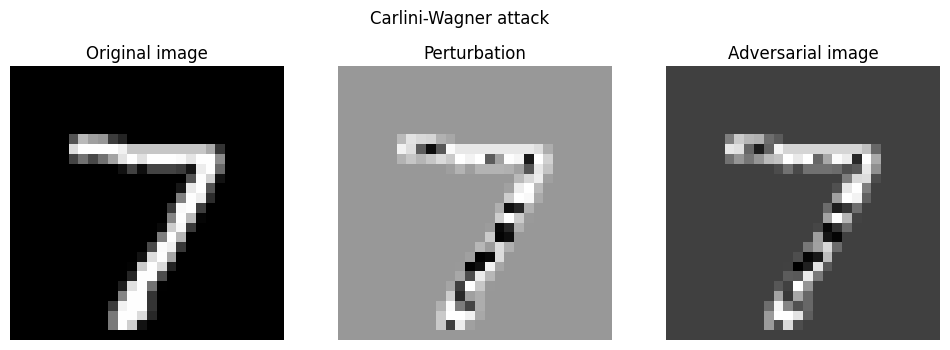

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

fig.suptitle('Carlini-Wagner attack')

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original image')
axes[0].axis('off')

axes[1].imshow(perturbation, cmap='gray')
axes[1].set_title('Perturbation')
axes[1].axis('off')

axes[2].imshow(original_image+perturbation, cmap='gray')
axes[2].set_title('Adversarial image')
axes[2].axis('off')

plt.show()